# <center>Analysis of U.S. Senate Polarization</center>
<center>By Nigel Story</center>

<img src="./images/repub-dem.jpg" style="height:400px">

---

## Contents

* [1. Introduction](#introduction)
    * [1.1 About the Data](#about-the-data)
    * [1.2 Methods](#methods)
    * [1.3 Packages and Dependencies](#packages-and-dependencies)
* [2. The Changing Political Map](#the-changing-political-map)
    * [2.1 Visualizing the Changing Political Map](#visualizing-the-changing-political-map)
* [3. Party-Line Voting](#party-line-voting)
    * [3.1 Party-Line Votes by Year](#party-line-votes-by-year)
* [4. Analysis of Vote-Based Political Clustering](#analysis-of-vote-based-political-clustering)
    * [4.1 Senator Vote Similarity](#senator-vote-similarity)
    * [4.2 Transform the Data](#transform-the-data)
    * [4.3 Apply K-Means](#apply-k-means)
        * [4.3.1 Plot Clusters](#plot-clusters)
    * [4.4 Centroid Distance Over Time](#centroid-distance-over-time)
* [5 Forecasting the Political Divide](#forecasting-the-political-divide)
    * [5.1 Long Short Term Memory Model (LSTM)](#lstm)
    * [5.2 Autoregressive Integrated Moving Average (ARIMA)](#arima)
    * [5.3 Comparing Forecasts](#comparing-forecasts)
* [6. Correlation Between Senate Polarization and Approval Ratings](#approval)
* [7. Conclusion](#conclusion)

---

## 1. Introduction <a class='anchor' id='introduction'></a>

The political landscape of the U.S. has been tumultuous in recent years, particulary following the election of President Trump and contemporary rise in popularity among the progressive ideals and figures in the political left, like Alexandria Ocasio-Cortez and Bernie Sanders. The rise in poplarity for politicians who subscribe to far-from-center ideas and policies has no doubt swayed moderates among both parties to adopt more polarizing views, and this has left the moderates and centerists among the electorate scrambling to pick a side.

But is this new, or has the U.S. always had to deal with hyper-partisanship? And how do these divisive politics affect the public perception of Congress? These are the questions this project sets out to answer.

### 1.1 About the Data <a class='anchor' id='about-the-data'></a>

For this analysis, we will be using data pertaining to senate seat data (senator id's, party, state, etc.), senate proceeding records (vote number, congress number and session, proceeding title, etc.), individual senators' voting histories, and Gallup poll data on Congress approval ratings. The data all range from the Congress of 1989 through 2020.

The data supporting this analysis were scraped from <a href="https://www.govtrack.us">govtrack.us</a> and from <a href="https://news.gallup.com">Gallup</a>. For a more detailed view of the web scrapers and ETL process, view the ETL notebooks in the project <a href="https://www.github.com/nastory/senate_votes">Git repository</a>.

### 1.2 Methods <a class='anchor' id='methods'></a>

For our analysis, we'll be using data pertaining to U.S. Senate votes as a proxy for measuring the division between parties.

After an overview of the changing political map, we'll be analyzing this data in three ways: the frequency of party-line votes, the distance between political cluster centroids, and the correlation between these measures and the public's opinion of Congress. 

First, we'll look at trend of purely party-line vote occurrences, with the idea that the frequency of party-line vote counts will serve as a measure of how strongly the parties of the Senate agree or disagree with one another. Next, we'll take a look at the individual senator level, where we will use K-Means to cluster senators based on their individual voting records, then we will use the distance between the centroids of our clusters to measure the distance between the voting habits of the average Democrat or Republican. We will then track the distances between centroids across sessions of congress, tracking the trend of polarization and making forecasts predicting whether or not the political divide is healing or worsening. Finally, we'll take a look at the correlation between the centroid distances and party-line votes and the public's opinion of Congress' performance, via the Gallup congressinal approval ratings polls.

Through this analysis, we'll be able to get idea of the U.S. political atmosphere with respect to past years, and get an idea of how the division between parties affects the public perception of Congress.

### 1.3 Packages and Dependencies <a class='anchor' id='packages-and-dependencies'></a>

Our environment will largely make use of the standard data science toolkit--namely Pandas, NumPy, Matplotlib, and Sci-Kit Learn. To supplement our visualization capabilities, we'll also be using Plotly and Seaborn. For our forecasting, we'll be making use of Pyramid ARIMA alongside the LSTM modeling from the Keras API.

For the creation of our centroid distance data, we'll need to rely on a functional pipeline to prepare the data and feed it into the `KMeans` class from sklearn. To achieve this, we'll use the functools package to compose our pipeline.

The data for our analysis is, for the most-part, stored in a local MySQL database, so we will be using a custom class for MySQL database interaction named `DBConnect`, which you can view the code for <a href="https://github.com/nastory/senate_votes/blob/main/helpers/db_connection.py">here</a>.

In [1]:
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "svg"

from helpers.db_connection import DBConnect

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import plaidml.keras as pk
pk.install_backend()
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pmdarima import auto_arima

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



---

## 2. The Changing Political Map <a class='anchor' id='the-changing-political-map'></a>

The political landscape of the U.S. is ever-changing, with states switching political preference and underdog political minority candidates winning and flipping states from one party to another.

But more than that, there is a hypothesis here to test. If it is the case that there exists an increase in the polarization of U.S. politics, then one would expect to see this reflected in the political map by a decrease in politically neutral states. Though this does not serve as proof of a worsening political divide, it does serve as evidence in support of that hypothesis.

We'll begin by crafting the SQL query to retrieve from our database the majority party of each state by year.

In [2]:
party_state_year_q = """
WITH t AS
/* count of senators by year, state, and party */
(
	SELECT
		s.`state`,
		v.`year`,
		s.`party`,
		COUNT(DISTINCT s.`senator_id`) AS cnt
	FROM senators s
	JOIN votes v ON v.`senator_id` = s.`senator_id`
	GROUP BY s.`state`, v.`year`, s.`party`
)


SELECT 
	m.`state`, 
	m.`year`, 
	CASE WHEN t.cnt=1 THEN 'Tie' ELSE t.`party` END AS party
FROM (
    /* maximum senator count by year and state, 
    to self-join for retrieving party with most senators */
	SELECT
		t.`state`,
		t.`year`,
		max(t.`cnt`) as max_cnt
	FROM t
	GROUP BY t.`state`, t.`year`
) m
JOIN t ON t.`state` = m.`state` 
	AND t.`year` = m.`year` 
	AND m.`max_cnt` = t.`cnt` /* join by maximum count to retrieve party with most senators */
;
"""

In [3]:
with DBConnect('senate') as cnx:
    state_parties = pd.read_sql(con=cnx.cnx, sql=party_state_year_q)

In [4]:
state_parties = state_parties.loc[state_parties['party']!='Vice President', :]

### 2.1 Visualizing the Changing Political Map <a class='anchor' id='visualizing-the-changing-political-map'></a>

Now that we have the data to model the political landscape, we'll create a gif using plotly so we can watch the states' parties change over time.

In [5]:
import gif

def plot_map(y):
    parties_y = state_parties.loc[state_parties['year']==y, :]
    fig = px.choropleth(locations=parties_y['state'], locationmode="USA-states", color=parties_y['party'], scope="usa",
                    color_discrete_map={'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Tie': 'gray'}, 
                        title="Senate Majority by State: {}".format(str(y)))
    return fig

@gif.frame
def plot_map_to_gif(y):
    return plot_map(y)


years = range(1989, 2021)
# Construct list of frames
frames = []
for y in years:
    frame = plot_map_to_gif(y)
    frames.append(frame)

# Save gif from frames with a specific duration for each frame in ms

gif.save(frames, 'images/senate_map_animation.gif', duration=1000)

<img src="images/senate_map_animation.gif" width="750" align="center">

### 2.2 Compare 1989 to 2020 <a class='anchor' id='compare-1989-to-2020'></a>

In comparing the earliest year, 1989, with the latest, 2020, we can see a big shift in the number of neutral, or tied, states. We go from having 23 "Tie" states in 1989 to having only 9 in 2020, which indicates stronger partisanship at the state level.

In [6]:
parties_1989 = state_parties.loc[state_parties['year']==1989, :]
parties_2020 = state_parties.loc[state_parties['year']==2020, :]

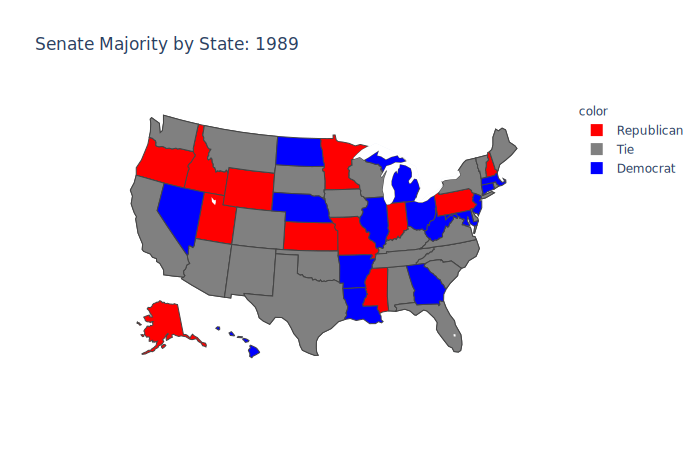

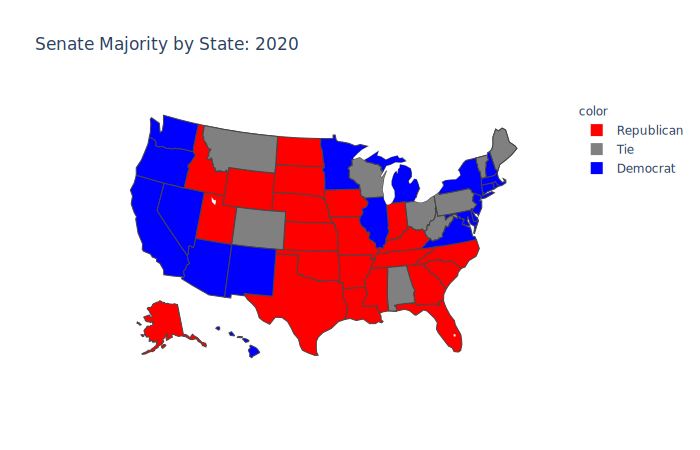

In [7]:
f1 = plot_map(1989)
f1.show()
f2 = plot_map(2020)
f2.show()

---

## 3. Party-Line Voting <a class='anchor' id='party-line-voting'></a>

As a simple indicator of polarization, we'll take a look at the number of party-line votes passed in each year of Congress. We'll define a "party-line vote" as a congressional act or procedure that only obtains the votes of a single party without any support from the opposing party. An example of this would be a bill passed with all Republicans voting "yea" and all Democrats voting "nay."

We'll query this out of the database by first creating a temporary table containing each congressional proceeding and the number of "yeas" and "nays" from each major political party. Next, we will query from that table the count of times that a proceeding received zero votes of "yea" or "nay" from a party, grouped by year.

This will give us data for how many party-line votes have occurred by year.

In [8]:
party_line_votes_q = """
WITH t AS (
SELECT
	v.`year`,
	v.`congress`,
	v.`vote_number`,
	COUNT(CASE WHEN s.party = 'Republican' AND v.`vote` = 'Yea' THEN v.`vote` END) AS rep_y_count,
    COUNT(CASE WHEN s.party = 'Republican' AND v.`vote` = 'Nay' THEN v.`vote` END) AS rep_n_count,
    COUNT(CASE WHEN s.party = 'Democrat' AND v.`vote` = 'Yea' THEN v.`vote` END) AS dem_y_count,
    COUNT(CASE WHEN s.party = 'Democrat' AND v.`vote` = 'Nay' THEN v.`vote` END) AS dem_n_count
FROM votes v
JOIN senators s ON s.`senator_id` = v.`senator_id`
GROUP BY
	v.`year`,
	v.`congress`,
	v.`vote_number`
)

SELECT
	t.`year`, 
    COUNT(CASE WHEN (t.`rep_y_count` = 0 AND t.`dem_n_count` = 0) OR (t.`rep_n_count` = 0 and t.`dem_y_count` = 0) then t.`vote_number` end) as party_line_vote_count
FROM t
GROUP BY
	t.`year`
"""

In [9]:
with DBConnect('senate') as cnx:
    party_line_df = pd.read_sql(sql=party_line_votes_q, con=cnx.cnx, index_col='year')

Now we will plot the results for visual analysis.

### 3.1 Party-Line Votes by Year <a class='anchor' id='party-line-votes-by-year'></a>

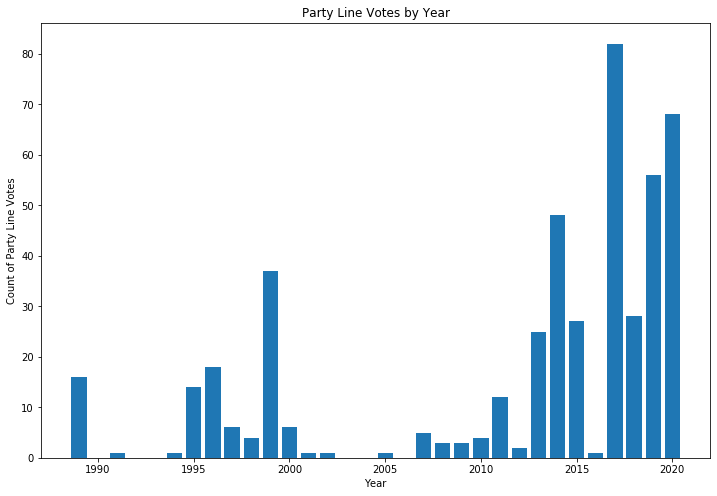

In [10]:
plt.figure(figsize=(12,8))
plt.title('Party Line Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count of Party Line Votes')
plt.bar(x=list(party_line_df.index), height=party_line_df['party_line_vote_count'])
plt.show()

This plot also supports the notion that hyper-partisanship and polarized politics are on the rise. Party-line votes have always existed in U.S. politics, but compared to the small bump in party-line votes that spanned 1994 to around 2000, the crescendo we've been experiencing since 2008 is dramatic.

Since 2006, the number of split votes along party lines has been trending upwards at a rapid pace, with only two small respites in 2012 and 2016. 2012 and 2016 are notably election years, so one might have surmised that there is some cooling of partisanship during the election cycle, but that notion is crushed by the data for 2020, which shows the second highest number of party-line votes.

Overall, this plot, too, serves as evidence for a worsening political divide in the U.S.

---

## 4. Analysis of Vote-Based Political Clustering <a class='anchor' id='analysis-of-vote-based-political-clustering'></a>

At a very basic level, political parties exist for one reason: each senator's constituents want them to vote in particular way, and by grouping themselves into political parties, the senators gain better leverage to advocate for their agendas. Therefore, it's not incorrect to assume by their grouping that members of a particular party should maintain voting records that are similar to the records of the other members of their party. Sure, outliers exists--like Senator Joe Manchin of West Virginia, a Democrat with fiscal values that align closer with conservatives--but overall, Republicans and Democrats will follow certain patterns that are distinct to each party.

In this section we will define a measure for the similarity between any two senators' voting records as well as try to measure the divide between the average Republican senator and the average Democrat senator.

### 4.1 Senator Vote Similarity <a class='anchor' id='senator-vote-similarity'></a>

A senator has three options when it comes to casting their votes: they can vote affirmative with "yea," negative with "nay," or they can abstain and not cast a vote. It stands to reason that if two senators both vote "yea" on a particular proceeding, then they are similar to some degree. Likewise, if one votes "yea" and the other votes "nay," then the two senators would be dissimilar. If the senators voted the same way for two proceedings, then they would be even more similar, and if they never voted the same way, then they would be extremely dissimilar. Let's take a look at two hypothetical senators' voting records.

<table>
    <thead>
        <th>Issue</th>
        <th>Senator 1 Vote</th>
        <th>Senator 2 Vote</th>
    </thead>
    <tbody>
        <tr>
            <td>Bill 1</td>
            <td>Yea</td>
            <td>Yea</td>
        </tr>
        <tr>
            <td>Bill 2</td>
            <td>Yea</td>
            <td>Nay</td>
        </tr>
        <tr>
            <td>Bill 3</td>
            <td>No Vote</td>
            <td>Yea</td>
        </tr>
    </tbody>
</table>

To model these senators' voting records we'll use the following mapping: "yea" -> 1, "nay" -> -1, "no vote" -> 0. The reason we've chosen to map the votes this way is that "yea" and "nay" should be on opposite ends of our domain, while "no vote" is more-or-less a neutral action and should therefore stand between "yea" and "nay." This transforms our senators' voting records to the following:

<table>
    <thead>
        <th>Issue</th>
        <th>Senator 1 Vote</th>
        <th>Senator 2 Vote</th>
    </thead>
    <tbody>
        <tr>
            <td>Bill 1</td>
            <td>1</td>
            <td>1</td>
        </tr>
        <tr>
            <td>Bill 2</td>
            <td>1</td>
            <td>-1</td>
        </tr>
        <tr>
            <td>Bill 3</td>
            <td>0</td>
            <td>1</td>
        </tr>
    </tbody>
</table>

We can now represent our senators' voting histories as vectors in N-dimensional space, where N is the number of proceedings voted on.

$$Senator1 = \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}$$

$$Senator2 = \begin{pmatrix} 1 \\ -1 \\ 1 \end{pmatrix}$$

And the similarity between these two vectors can be shown using Euclidean distance:

$$Similarity = \sqrt{(1-1)^2+(1+1)^2+(1-0)^2}$$
$$=\sqrt{5}$$
$$=2.23$$

This is will be how we model the voting records of our senators for this analysis, though the vectors will be of much higher dimension than 3. We will transform each senators voting record into vectors using the same mapping above, and then we will use a distance-based clustering algorithm, K-Means, to split Congress into to its two parties based on voting record similarity. Then we will compute the distance between the centroids of the clusters to use as our measure of similarity between the political parties overall.

### 4.2 Transform the Data <a class='anchor' id='transform-the-data'></a>

To prepare out data for clustering, we will need to query the voting records for each senator out of our database and then pivot the data such that each column represents how a senator voted on each proceeding.

We'll start by comparing the clusters that arise from the 1989 congress to the clusters of the 2020 congress.

In [11]:
vote_by_rep_q = """
SELECT
	CONCAT(v.`year`, '-', v.`vote_number`) AS year_vote_number,
	v.`senator_id`,
	s.`name`,
	s.`party`,
	CASE
		WHEN v.`vote` = 'Nay' THEN -1
		WHEN v.`vote` = 'Yea' THEN 1
		ELSE 0
	END AS vote
FROM votes v
JOIN senators s ON s.`senator_id` = v.`senator_id`
WHERE v.`year` = {}
"""

In [12]:
with DBConnect('senate') as cnx:
    vr_1989 = pd.read_sql(sql=vote_by_rep_q.format(1989), con=cnx.cnx)
    vr_2020 = pd.read_sql(sql=vote_by_rep_q.format(2020), con=cnx.cnx)

In [13]:
def pivot_votes(df):
    pv = pd.pivot_table(df, index=['senator_id', 'name', 'party'], columns=['year_vote_number'], fill_value=0)
    return pv

In [14]:
df_89 = pivot_votes(vr_1989)
df_89.head()

vote             \
year_vote_number                                  1989-00001 1989-00002   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00003 1989-00004   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00005 1989-00006   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00007 1989-00008   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         ...  \
year_vote_number                                  1989-00009 1989-00010  ...   
senator_id name                        party                             ...   
300005     Sen. Max Baucus             Democrat            1          1  ...   
300008     Sen. Joseph Biden Jr.       Democrat            1          1  ...   
300009     Sen. Jeff Bingaman          Democrat            1          1  ...   
300010     Sen. Christopher “Kit” Bond Republican          1          1  ...   
300012     Sen. John Breaux            Democrat            1          1  ...   

                                                                         \
year_vote_number                                  1989-00303 1989-00304   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat           -1          1   
300009     Sen. Jeff Bingaman          Democrat           -1          1   
300010     Sen. Christopher “Kit” Bond Republican         -1          1   
300012     Sen. John Breaux            Democrat           -1          1   

                                                                         \
year_vote_number                                  1989-00305 1989-00306   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat           -1         -1   
300008     Sen. Joseph Biden Jr.       Democrat           -1          1   
300009     Sen. Jeff Bingaman      

Above is our final dataframe containing the voting records of senators as row vectors. Now we will convert this Pandas dataframe into a NumPy array to pass into the K-Means algorithm.

In [15]:
x_89 = df_89.to_numpy()

In [16]:
df_20 = pivot_votes(vr_2020)
x_20 = df_20.to_numpy()

### 4.3 Apply K-Means <a class='anchor' id='apply-k-means'></a>

Now it's time to apply the K-Means algorithm to our data and analyze the results. K-Means is a clustering algorithm in which you specify the number clusters, *k*, you would like to create. A very basic description of the algorithm is this:

1. Randomly initialize k points in your space. These will be called the *centroids*.
2. Calculate the euclidean distance from each point in your dataset to each centroid.
3. Clusters will be defined by assigning each data point to the cluster of the centroid to which it is nearest. If a point is closest to centroid k_i, then it will be assigned to cluster k_i.
4. Take the mean of the data points in each cluster, and update your centroids to be equal to those mean values.
5. Repeat steps 2-5 until the mean of the cluster data points is equal to the existing centroids.

Since this is a distance-based clustering algorithm and it uses the Euclidean distance to define clusters, we are directly making use of our definition above of *Similarity* to segment our senators into parties.

Here we will be using the K-Means++ initialization to mitigate initialization bias with *k*=2 (the number of major U.S. political parties).

In [17]:
np.random.seed(seed=42)
kmeans = KMeans(n_clusters=2, init='k-means++')

In [18]:
km_89 = kmeans.fit(x_89)
magnitude_89 = kmeans.transform(x_89)
cluster_89 = kmeans.predict(x_89)

In [19]:
km_20 = kmeans.fit(x_20)
magnitude_20 = kmeans.transform(x_20)
cluster_20 = kmeans.predict(x_20)

In [20]:
df_89['cluster'] = cluster_89
df_89['mag_x'] = magnitude_89[:, 0]
df_89['mag_y'] = magnitude_89[:, 1]

In [21]:
df_20['cluster'] = cluster_20
df_20['mag_x'] = magnitude_20[:, 0]
df_20['mag_y'] = magnitude_20[:, 1]

Now that we have our clusters defined, let's visualize them by plotting the cluster magnitudes--that is, the distance of each point from each centroid.

#### 4.3.1 Plot Clusters <a class='anchor' id='plot-clusters'></a>

We'll start by defining a function to plot the cluster.

In [22]:
def plot_clusters(df, year, reflect=False):
    """Plot 2-d clusters of data for a particular year.
    
    Args:
        df (pandas.DataFrame): dataframe containing columns for cluster and magnitude
        year (int): year from which the data come. Used for graph title.
        reflect (bool): reflect the plot across the line x=y. Useful for comparing plots.
        
    Returns:
        None
    """
    
    plt.figure(figsize=(12,8))
    plt.title('Cluster Separation: {}'.format(year))
    color_dict = {'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Vice President': 'green'}
    if reflect:
        sns.scatterplot(data=df.reset_index(drop=False), x='mag_y', y='mag_x', hue='party', style='cluster', s=50, palette=color_dict)
    else:
        sns.scatterplot(data=df.reset_index(drop=False), x='mag_x', y='mag_y', hue='party', style='cluster', s=50, palette=color_dict)
    plt.plot()

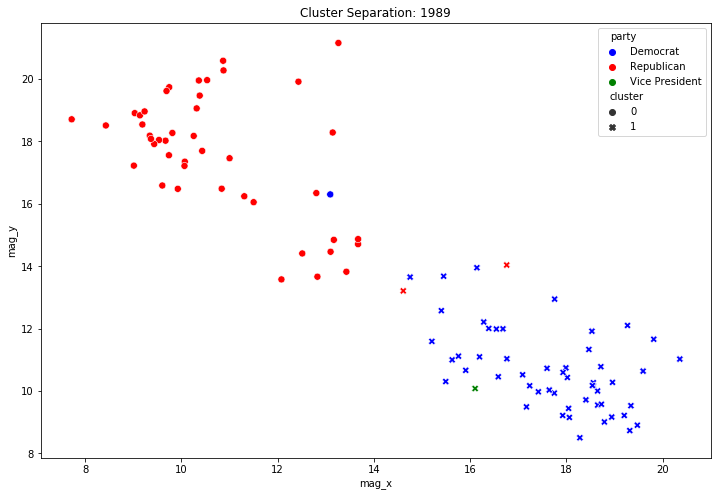

In [23]:
plot_clusters(df_89, 1989)

We can see above that in 1989, the resulting clusters are very close to one another, which is indicative of high similarity or agreement between the political parties. In fact, there are two Republicans whose voting records have resulted in them being assigned to the cluster representing the Democratic party and one Democrat grouped with the republicans.

This shows a fair amount of compromise and across-the-aisle work in the congress of 1989.

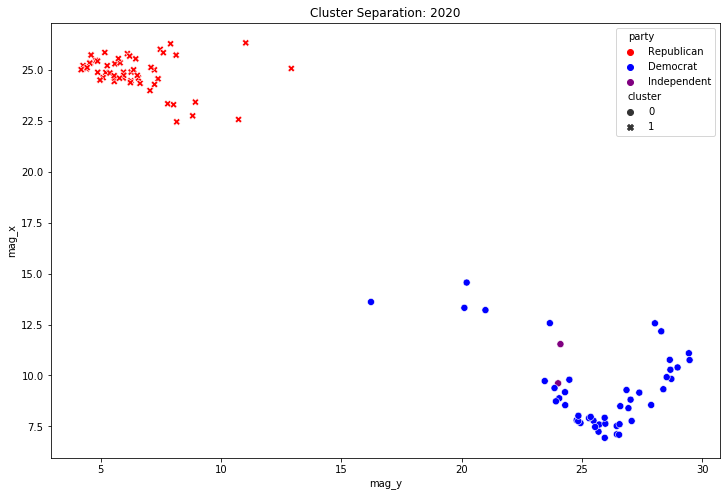

In [24]:
plot_clusters(df_20, 2020, reflect=True)

There is a stark contrast between the above graph showing 2020 and the one for 1989. Notably, there is zero cross-over between political parties and clusters. The parties have become more tightly grouped and the gap between clusters has widened.

We can also see in the above that the Democratic party has more senators with centerist leanings, as the Republican cluster has become more tightly knit with more consistent voting habits.

Let's calculate the distance between the centroids of these clusters to measure the changing relationship between Democrats and Republicans.

In [25]:
def euc_dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [26]:
centroid_89_0 = (df_89.loc[df_89['cluster']==0, 'mag_x'].mean(), df_89.loc[df_89['cluster']==0, 'mag_y'].mean())
centroid_89_1 = (df_89.loc[df_89['cluster']==1, 'mag_x'].mean(), df_89.loc[df_89['cluster']==1, 'mag_y'].mean())

centroid_20_0 = (df_20.loc[df_20['cluster']==0, 'mag_x'].mean(), df_20.loc[df_20['cluster']==0, 'mag_y'].mean())
centroid_20_1 = (df_20.loc[df_20['cluster']==1, 'mag_x'].mean(), df_20.loc[df_20['cluster']==1, 'mag_y'].mean())

In [27]:
print('Distance between centroids, 1989: {:.2f}'.format(euc_dist(centroid_89_0, centroid_89_1)))
print('Distance between centroids, 2020: {:.2f}'.format(euc_dist(centroid_20_0, centroid_20_1)))

Distance between centroids, 1989: 9.62
Distance between centroids, 2020: 24.66


This result is the strongest evidence so far for the hypothesis that political polarization is increasing, but it isn't quite the nail in the coffin. It could just be the case that 1989 was a particularly harmonious year and 2020 was a particularly acrimonious year. We need to look at the years in between and see what we can tell about the general trend of the centroid distances over the years. 

### 4.4 Centroid Distance Over Time <a class='anchor' id='centroid-distance-over-time'></a>

In order to plot the changing distance between cluster centroids, we'll need to perform several tasks in succession:

1. Query out the data for the relevant year.
2. Apply K-Means clustering.
3. compute the cluster centroids.
4. Calculate the distance between the centroids.
5. Finally, plot the results.

To achieve steps 1 through 4, we'll make use of a functional pipeline in which we'll define a function to complete each task and then compose the functions into a single composed function.

In [28]:
def get_data(yr):
    q = vote_by_rep_q.format(yr)
    with DBConnect('senate') as cnx:
        df = pd.read_sql(sql=q, con=cnx.cnx)
    
    df = pivot_votes(df)
    
    return df

def get_centroids(df):
    x = df.to_numpy()
    km = KMeans(n_clusters=2, init='k-means++').fit(x)
    mags = km.transform(x)
    clusts = km.predict(x)
    df['mag_x'] = mags[:, 0]
    df['mag_y'] = mags[:, 1]
    df['cluster'] = clusts
    
    c0 = (df.loc[df['cluster']==0, 'mag_x'].mean(), df.loc[df['cluster']==0, 'mag_y'].mean())
    c1 = (df.loc[df['cluster']==1, 'mag_x'].mean(), df.loc[df['cluster']==1, 'mag_y'].mean())
    
    return (c0, c1)

def euc_dist2(points):
    p1 = points[0]
    p2 = points[1]
    
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: g(f(x)), functions, lambda x: x)

centroid_distance = compose(get_data, get_centroids, euc_dist2)

Now with our `centroid_distance()` composed functions, we'll use a list comprehension to build out our dataframe of years and centroid distances.

In [29]:
dists = pd.DataFrame([[year, centroid_distance(year)] for year in range(1989, 2021)], columns=['year', 'dist'])

Let's plot our results along with an OLS regression trend line.

In [30]:
X = dists.to_numpy()[:, 0]
y = dists.to_numpy()[:, 1]

# show a trend line
lr = LinearRegression()
lr = lr.fit(X.reshape(-1,1), y)

In [31]:
x_hat = np.linspace(1989, 2026, num=100).reshape(-1, 1)
y_hat = lr.predict(x_hat)

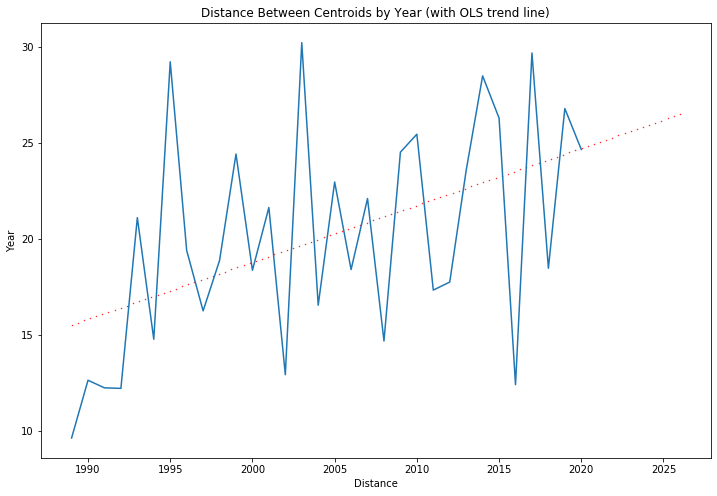

In [32]:
plt.figure(figsize=(12, 8))
plt.title('Distance Between Centroids by Year (with OLS trend line)')
plt.xlabel('Distance')
plt.ylabel('Year')
plt.plot(dists.set_index('year'))
plt.scatter(x=x_hat, y=y_hat, s=.2, color='r')
plt.show()

While our plot of centroid distances over time does seem to show an upward-sloping trend, indicating a general increase in party separation and polarization, it seems like the distances display a fairly wide variance. It also shows that, though in 2020 the distance between parties in large, it's not the greatest. In fact, it seems the year 2003 has the greatest amount of separation between Republicans and Democrats.

If we look below, we can see that the year 2020 only sits at about the 75th percentile.

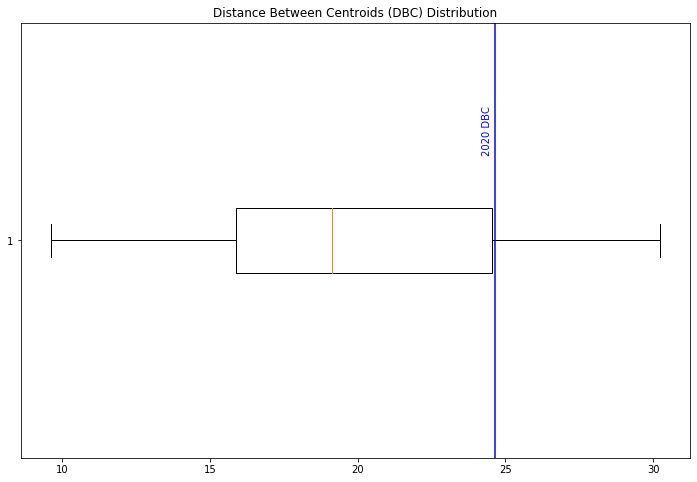

In [33]:
plt.figure(figsize=(12, 8))
plt.title('Distance Between Centroids (DBC) Distribution')
plt.annotate('2020 DBC', xy=(24.2,1.2), rotation=90, color='b')
plt.boxplot(dists['dist'], vert=False)
plt.axvline(x=dists.loc[dists['year']==2020, 'dist'].values[0], color='b', label='axvline - full height')

While 2020 may not be the worst year in terms of political polarization, we have now confirmed that the increasing polarity does exist, and it's heading in the direction of further separation.

Next, we'll look at the forecasts and try to predict how this divide is going to look in the future.

---

## 5. Forecasting the Political Divide <a class='anchor' id='forecasting-the-political-divide'></a>

The political divide has gotten worse over the past 40 years, as indicated by both the frequency of party-line votes and the increasing distance between party clusters, so what does this spell for the future of politics? In this section, we'll create two forecasts to try to predict where the political divide will fall over the next five years. 

Our first approach will be the Long Short-Term Memory (LSTM) model. This approach makes use of recurrent artificial neural networks to ingest the sequence of centroid distances and output prediction sequences. The key to this model's success is that it's able to maintain a memory of recent sequences of data that have passed through it, allowing it to make predictions that are informed by recent history. The full story of the LSTM's inner workings is much more complicated, however, so I've linked to a more complete description <a href="https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21">here</a>.

The second approach takes a more traditional statistical approach. Autoregressive Integrated Moving Average (ARIMA) models are statistical models that at their heart work very similarly to multiple linear regression. In a multiple regression model, we forecast the variable of interest using a linear combination of predictors. In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable (<a href="https://otexts.com/fpp2/AR.html">citation</a>). The moving average and integration parameters play a roll, as well, in fine tuning and obtaining more accurate forecasts. You can read more about it <a href="https://otexts.com/fpp2/non-seasonal-arima.html">here</a>.

Let's create these two models and get an idea of what the future might hold for U.S. politics.

### 5.1 Long Short-Term Memory Model <a class='anchor' id='lstm'></a>

In [34]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [35]:
n_features = 1
n_steps = 5

X, y = split_sequence(dists['dist'].to_list(), n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [36]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


In [37]:
model.fit(X, y, epochs=200, verbose=0)

In [38]:
preds = model.predict(X[-5:])
preds

array([[15.488109],
       [24.670834],
       [18.482538],
       [25.98647 ],
       [19.673717]], dtype=float32)

In [39]:
preds = pd.DataFrame(list(zip(range(2021, 2026), preds.reshape(-1))), columns=['year', 'dist']).set_index('year')
preds

,dist
year,
2021,15.488109
2022,24.670834
2023,18.482538
2024,25.986469
2025,19.673717


### 5.2 Autoregressive Integrated Moving Average <a class='anchor' id='arima'></a>

In [40]:
arima=auto_arima(dists.set_index('year'), 
          start_p=0, d=1, start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5, max_D=5,
          max_Q=5, seasonal=False,
          error_action='warn', trace=True,
          supress_warnings=True, stepwise=True,
          random_state=20, n_fits=50)

Fit ARIMA: order=(0, 1, 0); AIC=223.173, BIC=226.041, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=205.981, BIC=210.283, Fit time=0.015 seconds
Fit ARIMA: order=(0, 1, 1); AIC=198.850, BIC=203.152, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 1); AIC=197.772, BIC=203.508, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 2); AIC=201.076, BIC=208.246, Fit time=0.093 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 1); AIC=199.640, BIC=206.810, Fit time=0.105 seconds
Total fit time: 0.330 seconds


/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/nastory/opt/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning:

Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")



In [41]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   31
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -94.886
Method:                       css-mle   S.D. of innovations              4.835
Date:                Mon, 11 Oct 2021   AIC                            197.772
Time:                        19:12:26   BIC                            203.508
Sample:                             1   HQIC                           199.642
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2880      0.072      3.989      0.000       0.146       0.429
ar.L1.D.y     -0.3131      0.172     -1.825      0.079      -0.649       0.023
ma.L1.D.y     -0.9999      0.120     -8.330      0.000      -1.235      -0.765
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.1941           +0.0000j            3.1941            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [42]:
arima_preds, ci = arima.predict(n_periods = 5, return_conf_int=True, alpha=.2)
arima_preds = pd.DataFrame(list(zip(range(2021, 2026), arima_preds.reshape(-1))), columns=['year', 'dist']).set_index('year')
arima_preds

,dist
year,
2021,24.885556
2022,25.192018
2023,25.474222
2024,25.764020
2025,26.051441


### 5.3 Comparing Forecasts <a class='anchor' id='comparing-forecasts'></a>

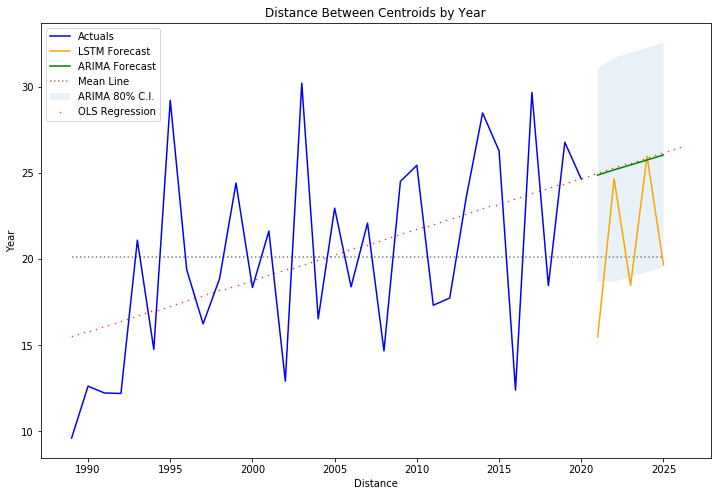

In [43]:
plt.figure(figsize=(12, 8))
plt.title('Distance Between Centroids by Year')
plt.xlabel('Distance')
plt.ylabel('Year')
plt.plot(dists.set_index('year'), color='b', label='Actuals')
plt.plot(preds, color='orange', label='LSTM Forecast')
plt.plot(arima_preds, color='green', label='ARIMA Forecast')
plt.hlines(y=dists['dist'].mean(), xmin=1989, xmax=2025, color='gray', linestyle='dotted', label="Mean Line")
plt.fill_between(list(arima_preds.index), [y[0] for y in ci], [y[1] for y in ci], alpha=0.1, label='ARIMA 80% C.I.')
plt.scatter(x=x_hat, y=y_hat, s=.2, color='r', label='OLS Regression')
plt.legend(loc=2)
plt.show()

Above we have the actual centroid distances (blue) with the two forecasts, LSTM and ARIMA, shown in yellow and green, respectively. We've also extrapolated and overlaid the OLS regression line from earlier.

There are two interesting forecast interpretations between our two models: while the ARIMA model somewhat expectedly follows a very similar line to the OLS line, the LSTM take a more optimistic view, occupying the lower 40% of the ARIMA model's confidence band.

In [44]:
x = dists['year'].to_numpy().reshape(-1,1)
y = dists['dist'].tolist()
y_hat = lr.predict(x)

print(f"R^2 Score: {round(r2_score(y, y_hat), 3)}")

R^2 Score: 0.227


What I find especially interesting is that the R^2 value for the OLS line, which the ARIMA model also follows, is only 22.7%, so that model performs only slightly better than simply using the mean value of the data, which would assume no growth in the political divide. And the LSTM adopts that more optimistic view -- zig-zagging about the mean value of 20.1 and trending only slightly upwards.



## 6. Correlation Between Senate Polarization and Approval Ratings <a class='anchor' id='approval'></a>

The final analysis of this project will be exploring how polarized politics affect the general public's opinion of congress. We'll explore this affect by pulling in data from the latest Gallup polls and examining the correlation between the percentage approval rating of congress and the polarization metrics we've used above--namely, the number of part-line votes and the distance between cluster centroids.

The Gallup data is collected on a monthly basis, so we'll start by aggregating the data to the year level using the mean approval rating.

In [45]:
congress_approval = pd.read_pickle('./gallup_congress_approval.pkl')
congress_approval.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 343 entries, 2021-08-02 to 1990-10-11
Data columns (total 3 columns):
approve       343 non-null int64
disapprove    343 non-null int64
no_opinion    343 non-null int64
dtypes: int64(3)
memory usage: 10.7 KB


In [46]:
congress_approval['year'] = [d for d in congress_approval.reset_index(drop=False)['date'].dt.year]

In [47]:
yearly_approval = congress_approval.groupby('year')['approve'].mean()

Next, we'll combine the aggregated Gallup data with our polarization measures.

In [48]:
apr_v_pol = pd.merge(left=dists, right=yearly_approval.reset_index(), how='inner') # distance between centroids
apr_v_pol = pd.merge(left=apr_v_pol, right=party_line_df.reset_index(), how='inner') # party-line votes

In [49]:
apr_v_pol.set_index('year', inplace=True)

In [50]:
apr_v_pol.corr()

,dist,approve,party_line_vote_count
dist,1.000000,-0.069020,0.574307
approve,-0.069020,1.000000,-0.335419
party_line_vote_count,0.574307,-0.335419,1.000000


Above, we can see moderate correlation between the number of party-line votes and distance between the centroids of political clusters, along with moderate negative correlation between congress' approval rating and the number of party-line votes. However, there is negligible correlation between congress' approval rating and distance between centroids.

One might assume a certain amount of transitivity here -- distance between centroids is correlated to party-line votes, and party-line votes is negatively correlated to public opinion -- so one could assume a similar negative correlation between distance between centroids and public opinion; however, the relationship between distance between centroids and public opinion is barely existent.

By examining the plots together, however, we can see that this is accurate: public opinion and party-line votes follow similar patterns, and distance between centroids seems to be just an upward-trending random walk.

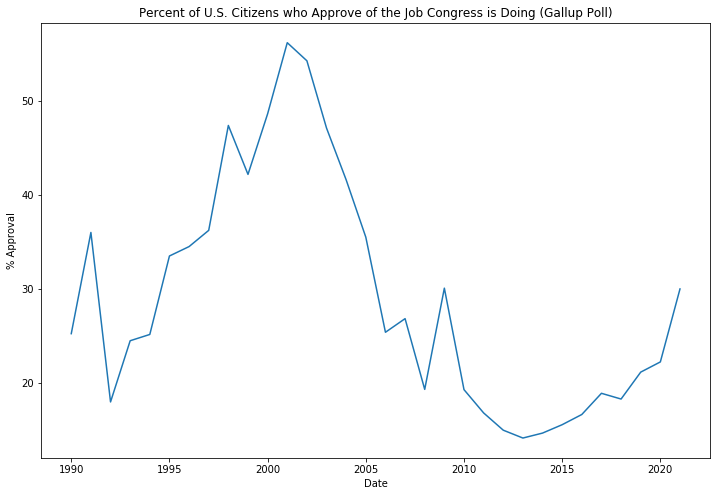

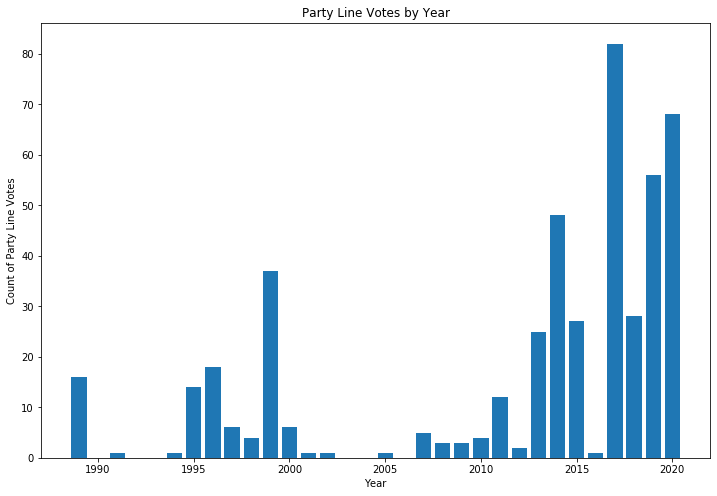

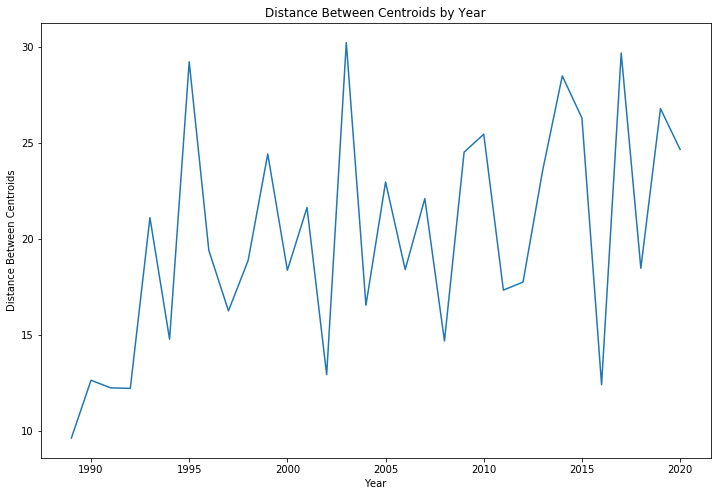

In [51]:
plt.figure(figsize=(12,8))
plt.plot(yearly_approval)
plt.title("Percent of U.S. Citizens who Approve of the Job Congress is Doing (Gallup Poll)")
plt.xlabel('Date')
plt.ylabel("% Approval")

plt.figure(figsize=(12,8))
plt.title('Party Line Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count of Party Line Votes')
plt.bar(x=list(party_line_df.index), height=party_line_df['party_line_vote_count'])
plt.show()

plt.figure(figsize=(12,8))
plt.title('Distance Between Centroids by Year')
plt.xlabel('Year')
plt.ylabel('Distance Between Centroids')
plt.plot(dists.set_index('year'))
plt.show()

---

## Conclusion <a class='anchor' id='conclusion'></a>

In this project we sought out to explore the hypothesis that the U.S. is in a worsening state of hyper-partisan, polarized politics, and we found three key pieces of evidence in support of that hypothesis. First, we saw that at the state level, there are fewer states with balanced senate parties in 2020 than there were in 1989, showing states are becoming more devoted to their political parties. Second, we analyzed the number of party-line votes taking place in the Senate, and we saw that since 2007 the number of party-line votes per year has sky-rocketed, indicating a decrease in senators' ability or desire to work across the aisle. Finally, we observed that the measurable distance between the centroids of the defining political clusters has maintained an increasing trend since 1989, showing that political divisions are only getting worse year over year.

As additional point of insight, we explored the correlation between the general public's opinion of congress and our measures of political polarity, and we saw that public opinion and the number of party-line votes are inversely correlated, meaning that the public wants congress to work together and decrease the frequency of partisan votes.

In conclusion, though 2020 is a year with high levels of political division, it is not the highest level of division on record--that honor going to 2003. However, if the U.S. political landscape keeps heading in its current direction, we can be sure to break the 2003 record and continue down the path of worsening division, to the benefit of no one.